<center><h1>Apollo Hospitals</h1></center>

The company wants to know:

- Which variables are significant in predicting the reason for hospitalization for different regions

- How well some variables like viral load, smoking, Severity Level describe the hospitalization charges

## Column Profiling-

- Age: This is an integer indicating the age of the primary beneficiary (excluding those above 64 years, since they are generally covered by the government).
- Sex: This is the policy holder's gender, either male or female
- Viral Load: Viral load refers to the amount of virus in an infected person's blood
- Severity Level: This is an integer indicating how severe the patient is
- Smoker: This is yes or no depending on whether the insured regularly smokes tobacco.
- Region: This is the beneficiary's place of residence in Delhi, divided into four geographic regions - northeast, southeast, southwest, or northwest
- Hospitalization charges: Individual medical costs billed to health insurance

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder

sns.set(rc={"figure.dpi":150})
sns.set_style("whitegrid")

In [2]:
data = pd.read_csv("scaler_apollo_hospitals.csv", index_col=0)
data.head()

,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,19,female,yes,southwest,9.30,0,42212
1,18,male,no,southeast,11.26,1,4314
2,28,male,no,southeast,11.00,3,11124
3,33,male,no,northwest,7.57,0,54961
4,32,male,no,northwest,9.63,0,9667


## 1. Analysing Basic metrics

In [3]:
data.shape

(1338, 7)

In [4]:
## No null values in data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      1338 non-null   int64  
 1   sex                      1338 non-null   object 
 2   smoker                   1338 non-null   object 
 3   region                   1338 non-null   object 
 4   viral load               1338 non-null   float64
 5   severity level           1338 non-null   int64  
 6   hospitalization charges  1338 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 83.6+ KB


In [5]:
## 4 columns have very less unique values

data.nunique(dropna=False)

age                          47
sex                           2
smoker                        2
region                        4
viral load                  462
severity level                6
hospitalization charges    1320
dtype: int64

In [6]:
## replacing " " in column names with "_"
data.columns = [i.replace(" ", "_") for i in data.columns]

## converting appropriate columns to category type
data = data.astype({i:"category" for i in ["sex", "smoker", "region", "severity_level"]})
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   age                      1338 non-null   int64   
 1   sex                      1338 non-null   category
 2   smoker                   1338 non-null   category
 3   region                   1338 non-null   category
 4   viral_load               1338 non-null   float64 
 5   severity_level           1338 non-null   category
 6   hospitalization_charges  1338 non-null   int64   
dtypes: category(4), float64(1), int64(2)
memory usage: 47.7 KB


In [7]:
## age ranges from 18 to 64 with mean 39.2
## viral_load ranges from 5.3 to 17.7 with mean 10.2
## hospitalization_charges ranges from 2805 to 159426 with mean 33176

data.describe()

,age,viral_load,hospitalization_charges
count,1338.000000,1338.000000,1338.000000
mean,39.207025,10.221233,33176.058296
std,14.049960,2.032796,30275.029296
min,18.000000,5.320000,2805.000000
25%,27.000000,8.762500,11851.000000
50%,39.000000,10.130000,23455.000000
75%,51.000000,11.567500,41599.500000
max,64.000000,17.710000,159426.000000


In [8]:
## More male data is there
## large number of non smokers
## 0 severity_level is most common

data.describe(include=["O", "category"])

,sex,smoker,region,severity_level
count,1338,1338,1338,1338
unique,2,2,4,6
top,male,no,southeast,0
freq,676,1064,364,574


In [9]:
## Checking % proportion for category columns

for column in ["sex", "smoker", "severity_level", "region"]:
    print(column+' % Proportion:')
    display(
        round((data[column].value_counts(normalize=True) *100), 2)
    )
    print('-'*50)


sex % Proportion:


male      50.52
female    49.48
Name: sex, dtype: float64

--------------------------------------------------
smoker % Proportion:


no     79.52
yes    20.48
Name: smoker, dtype: float64

--------------------------------------------------
severity_level % Proportion:


0    42.90
1    24.22
2    17.94
3    11.73
4     1.87
5     1.35
Name: severity_level, dtype: float64

--------------------------------------------------
region % Proportion:


southeast    27.20
northwest    24.29
southwest    24.29
northeast    24.22
Name: region, dtype: float64

--------------------------------------------------


In [10]:
pd.crosstab(index=[data.sex,  data.smoker,],
            columns=[data.region, ],
            margins=True, 
            normalize=True
            )\
                .style.background_gradient(cmap='YlGnBu')\
                    .format('{:.2%}')


In [11]:
pd.crosstab(index=data.region, 
            columns=data.severity_level, 
            margins=True,
            normalize=True,
            )\
                .style.background_gradient(cmap='YlGnBu')\
                    .format('{:.2%}')

severity_level,0,1,2,3,4,5,All
region,,,,,,,
northeast,10.99%,5.75%,3.81%,2.91%,0.52%,0.22%,24.22%
northwest,9.87%,5.53%,4.93%,3.44%,0.45%,0.07%,24.29%
southeast,11.73%,7.10%,4.93%,2.62%,0.37%,0.45%,27.20%
southwest,10.31%,5.83%,4.26%,2.77%,0.52%,0.60%,24.29%
All,42.90%,24.22%,17.94%,11.73%,1.87%,1.35%,100.00%


In [12]:
pd.crosstab(index=data.region, 
            columns=data.sex, 
            margins=True,
            normalize=True,
            )\
                .style.background_gradient(cmap='YlGnBu')\
                .format('{:.2%}')


sex,female,male,All
region,,,
northeast,12.03%,12.18%,24.22%
northwest,12.26%,12.03%,24.29%
southeast,13.08%,14.13%,27.20%
southwest,12.11%,12.18%,24.29%
All,49.48%,50.52%,100.00%


<div class="alert alert-block alert-info">
<h3>Observations:</h3> 
    1. Male and female proportion is almost equal.<br>
    2. Around 80% people in dataset are non smoker.<br>
    3. More than 60% people have severity level less than 2.<br>
    4. More male smokers are there in southeast and southwest region than female smokers.<br>
    5. Southeast region has highest severity 0 level patients.<br>
    6. Southeast region has around 1% more male patients than female.<br> 
    7. That might be because around 2% more male smokers are there in southeast than female smokers.<br>
</div>

<hr>

## 2. Univariate Analysis

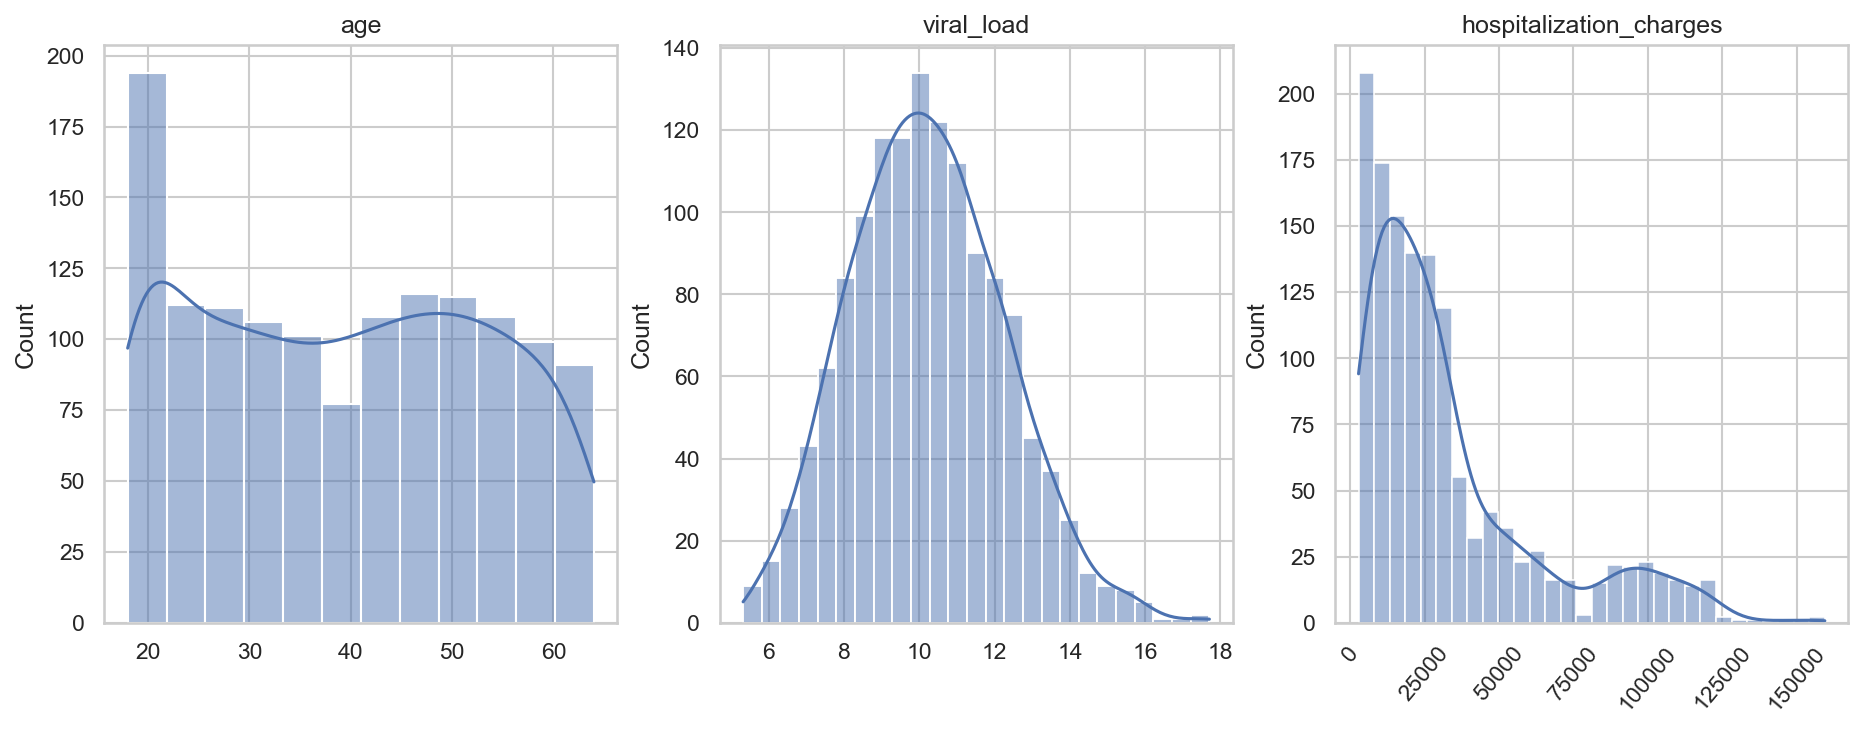

In [13]:
## histograms and boxplot for numerical columns

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
plt.subplots_adjust(hspace=0.3)

for i, ax in zip(data.select_dtypes(exclude='category'), axs.ravel()):
    sns.histplot(data, x=i, kde=True, ax=ax)
    ax.set_title(i)
    ax.set_xlabel('')
    plt.xticks(rotation=50)


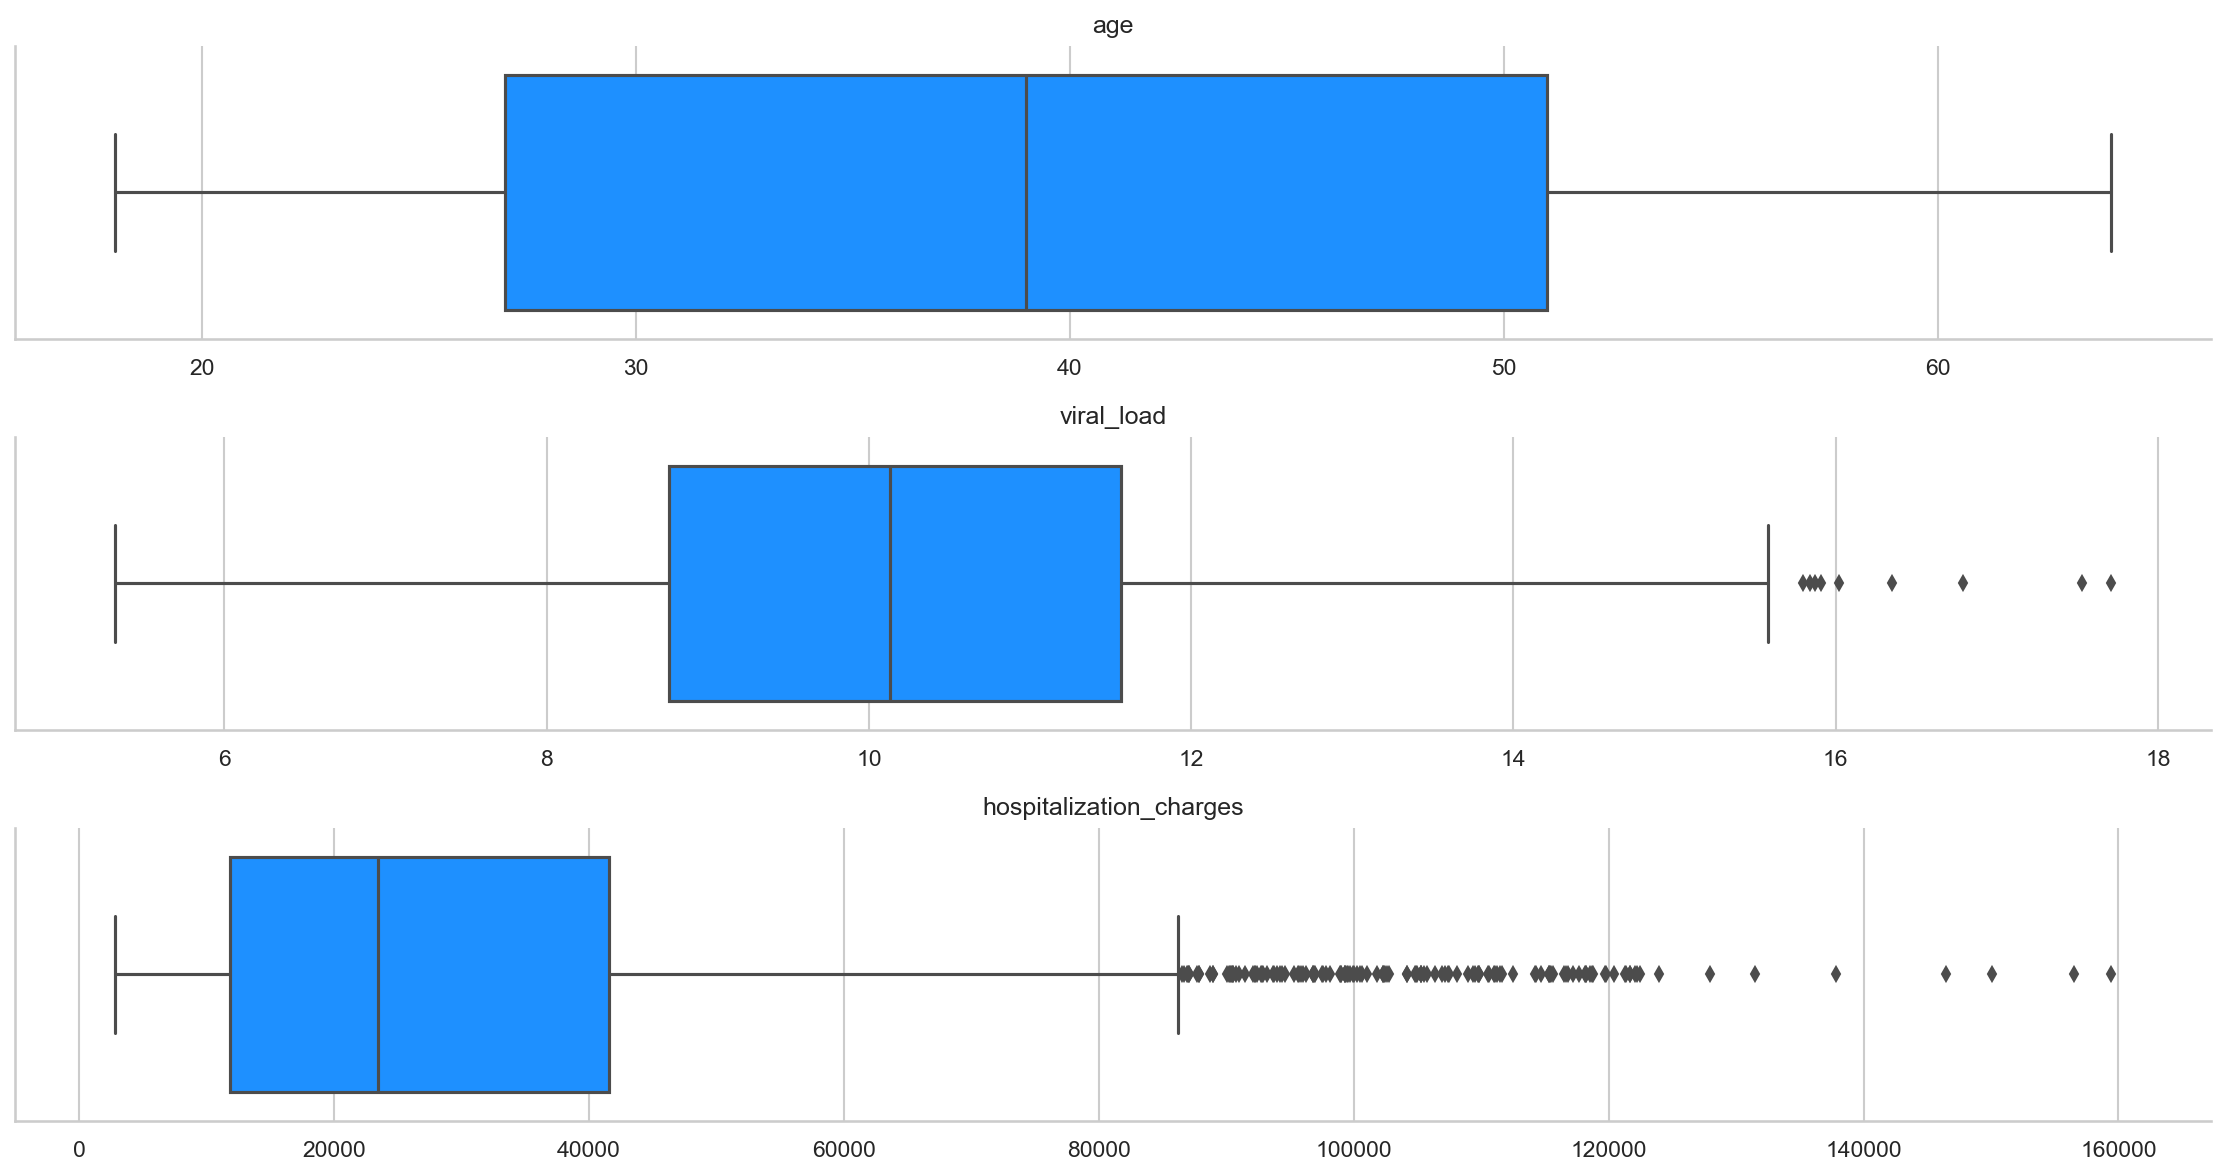

In [14]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 8))
plt.subplots_adjust(hspace=0.6)

for i, ax in zip(data.select_dtypes(exclude=['object', 'category']), axs.ravel()):
    sns.boxplot(x=data[i], ax=ax,  boxprops={'facecolor': 'dodgerblue'})
    sns.despine()
    ax.set_title(i)
    ax.set_xlabel("")

fig.tight_layout()

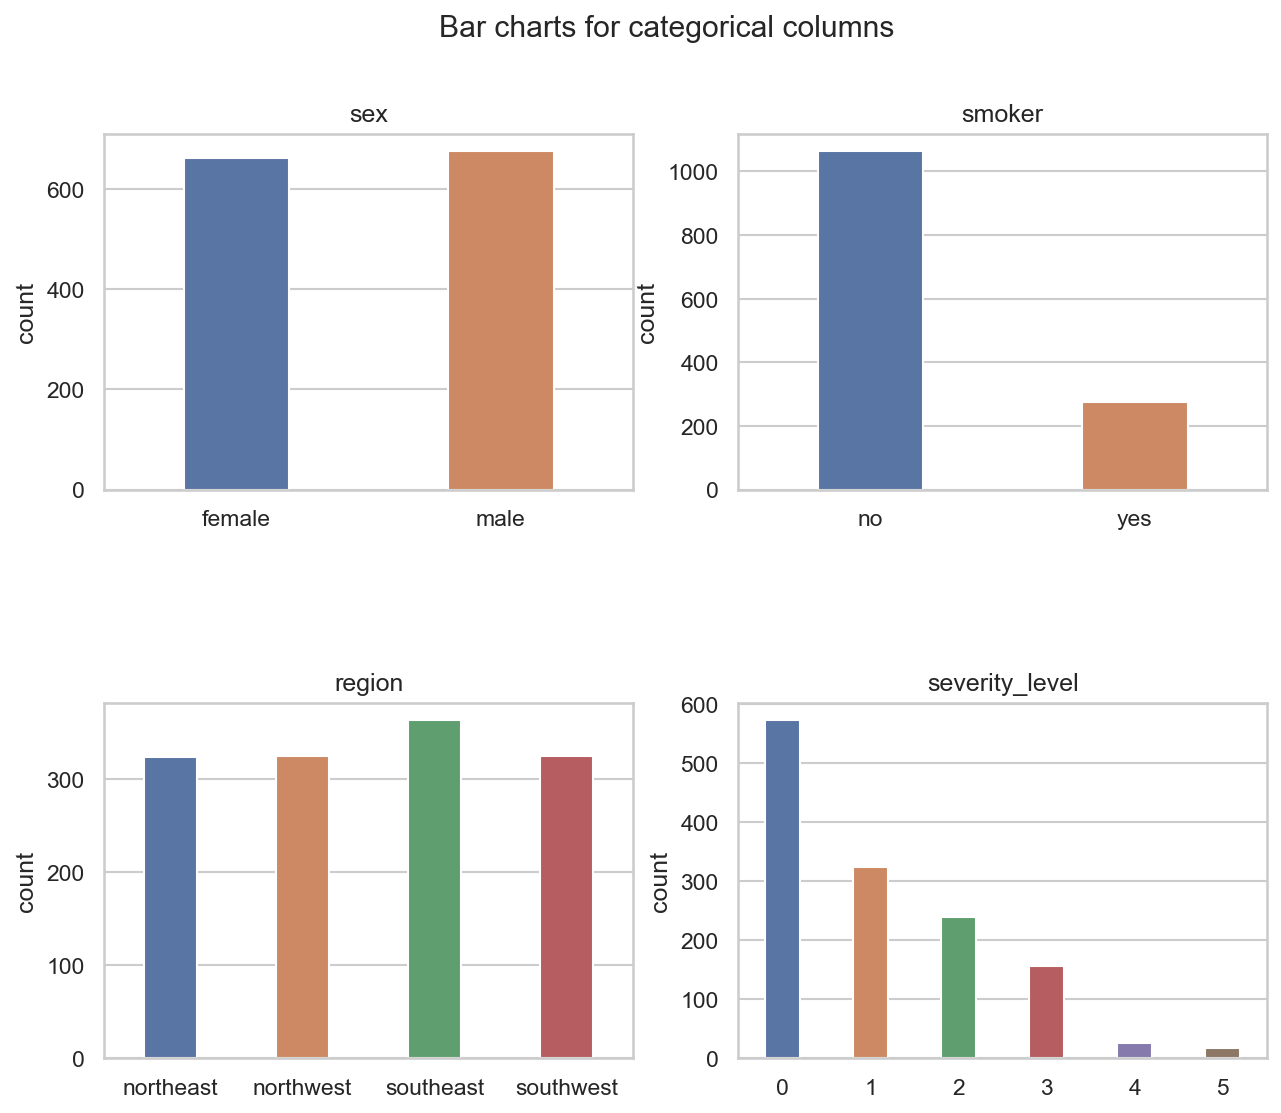

In [15]:
## count plots for category columns
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
plt.subplots_adjust(hspace=0.6)
fig.suptitle("Bar charts for categorical columns")

for i, ax in zip(data.select_dtypes(['category']), axs.ravel()):
    sns.countplot(x=data[i],width=0.4, ax=ax)
    ax.set_title(i)
    ax.set_xlabel('')

<div class="alert alert-block alert-info">
<h3>Observations:</h3> 
    1. Patients count is highest around age of 20 years.<br>
    2. Viral load approximately following Normal distribution.<br>
    3. Hospitalization charges are right skewed and having many outliers.<br>
    4. Patients are distributed equally in all region and of both sex.<br>
    5. Count of patients decreasing as the severity level increasing.<br>
    6. Significantly large number of non smokers than smokers.<br>
</div>

<hr>

## 3. Bivariate Analysis

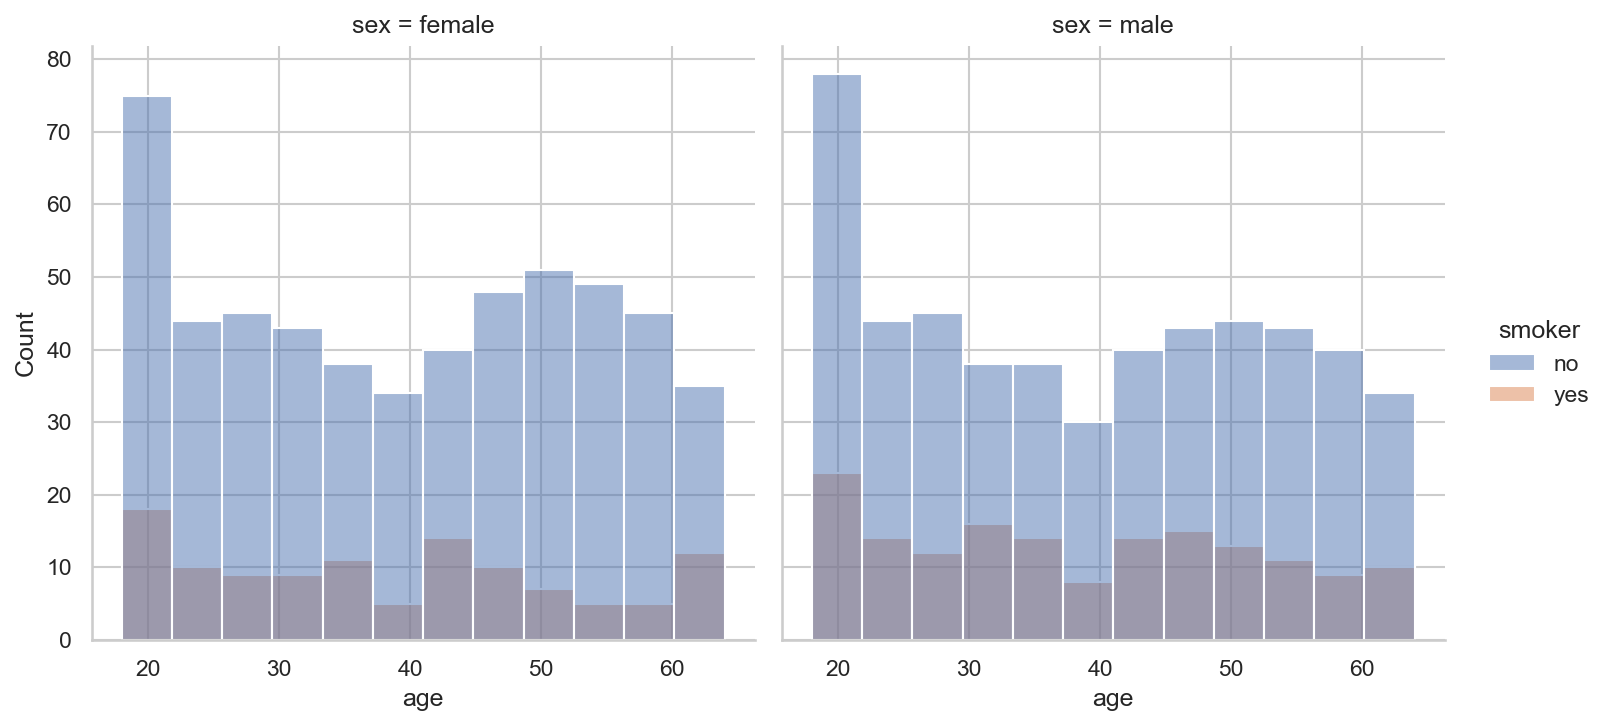

In [191]:
sns.displot(data, x="age", hue="smoker", col="sex",  )

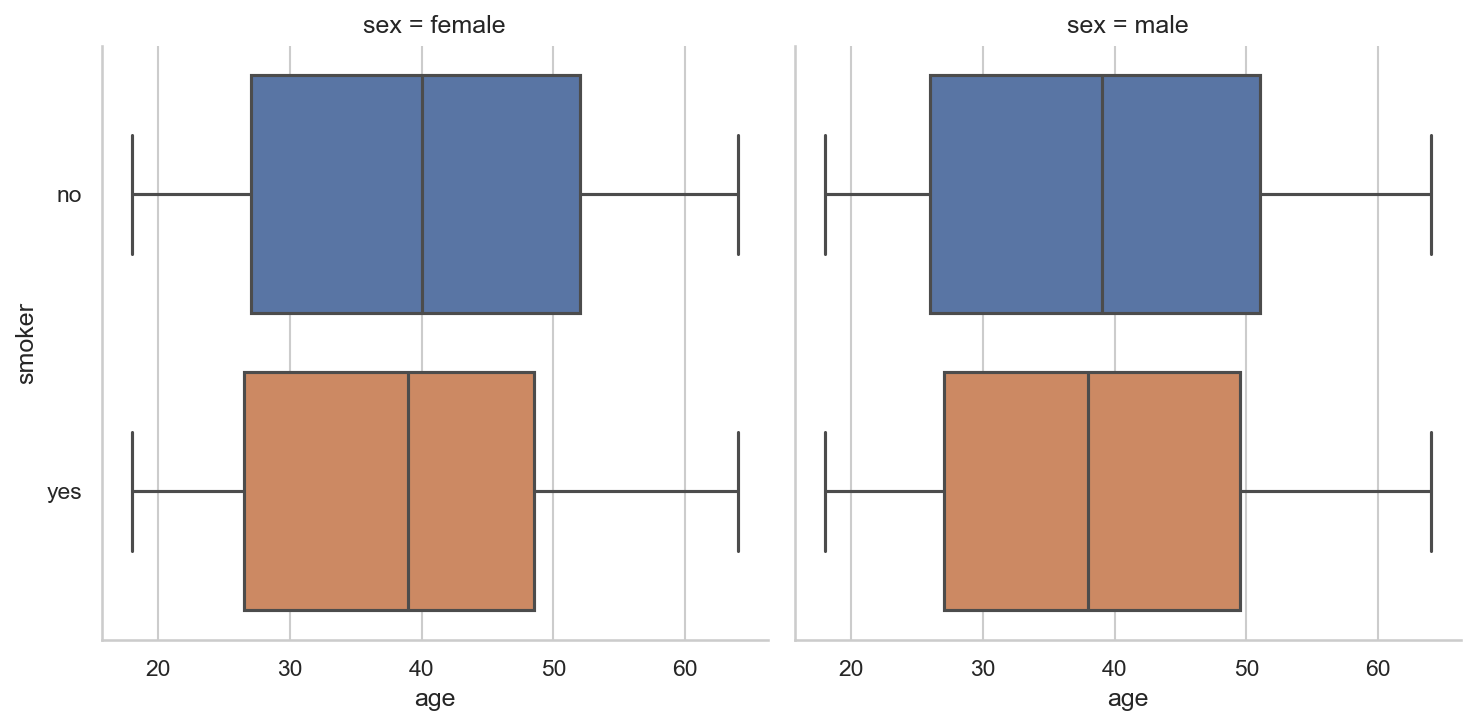

In [193]:
sns.catplot(data, x="age", y="smoker", col="sex", kind="box")

- No difference in age of smoker and non smoker for male and female
- Median age is around 39 years for male/female and smoker/non_smoker

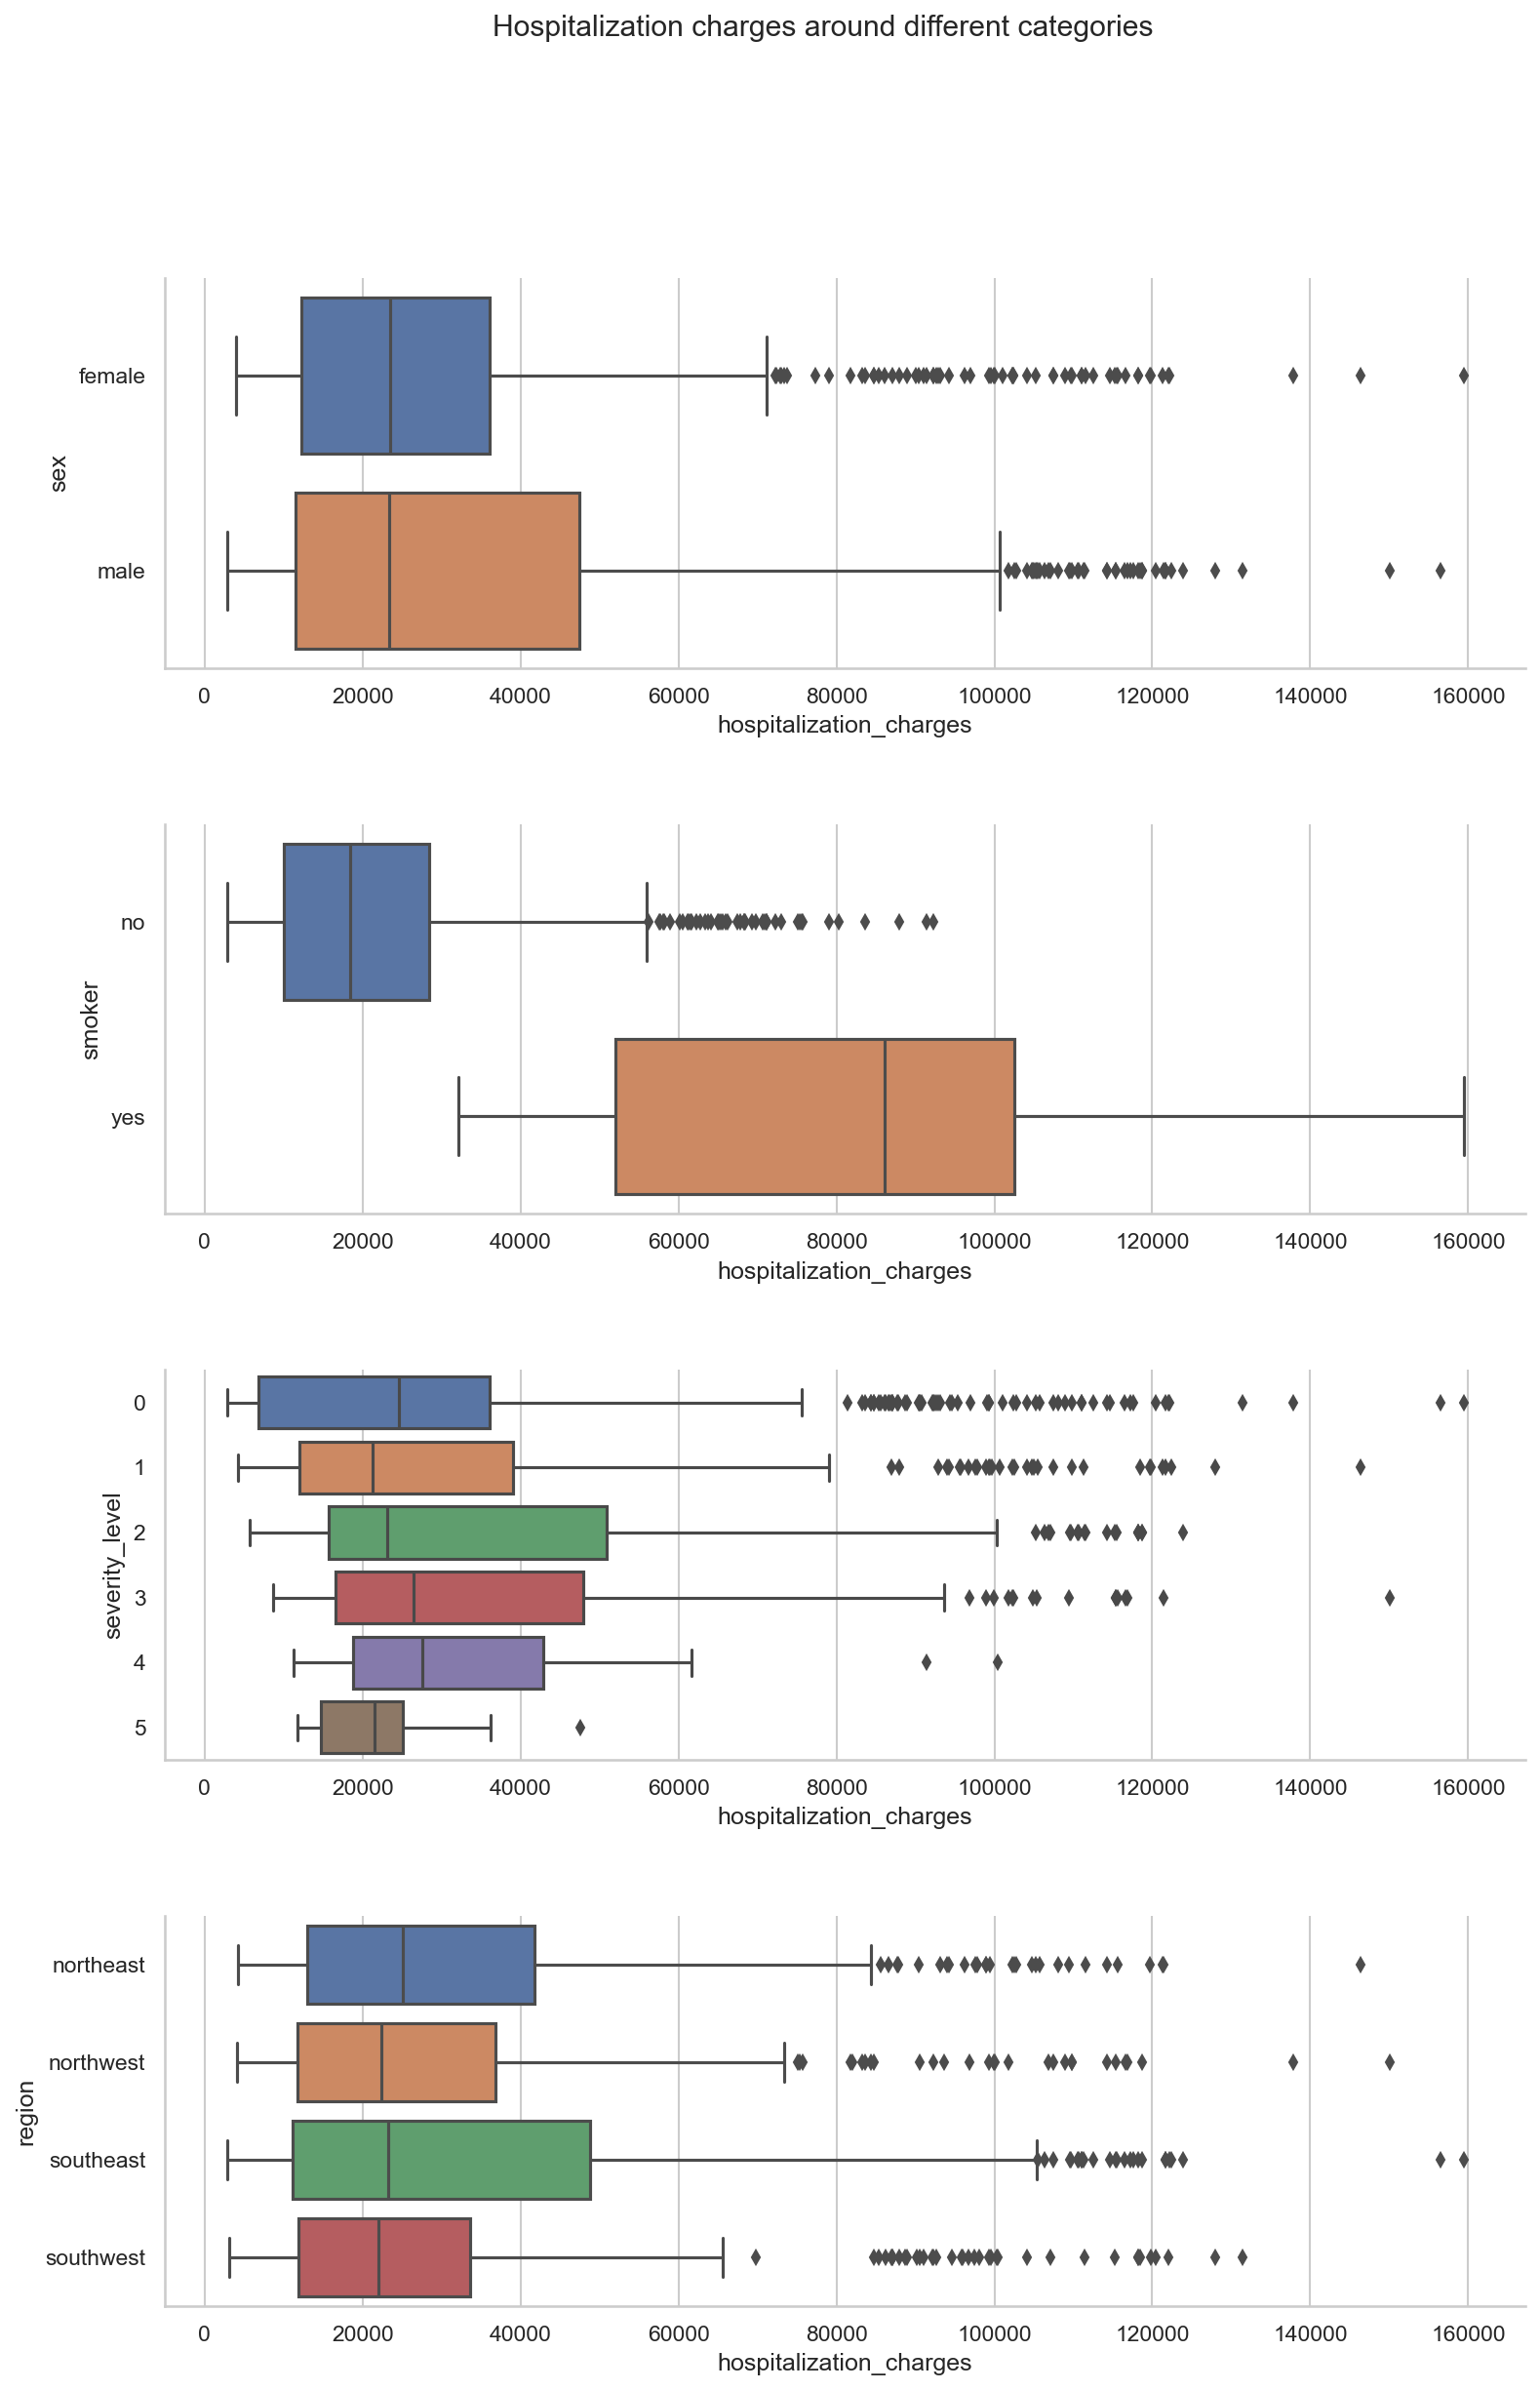

In [17]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(12, 18))
plt.subplots_adjust(hspace=0.4)

fig.suptitle("Hospitalization charges around different categories")

for col, ax in zip(["sex", "smoker", "severity_level", "region"], axs.ravel()):
    sns.boxplot(data, y=col, x="hospitalization_charges", ax=ax, )
    sns.despine()

- Male and female have around same mean hospitalization charges and both are having outliers.
- Lot of outliers for non smokers and for smokers hospitalization charges are more than non smokers.
- All severity levels and regions have outliers.
- Mean is approximately same around different regions.

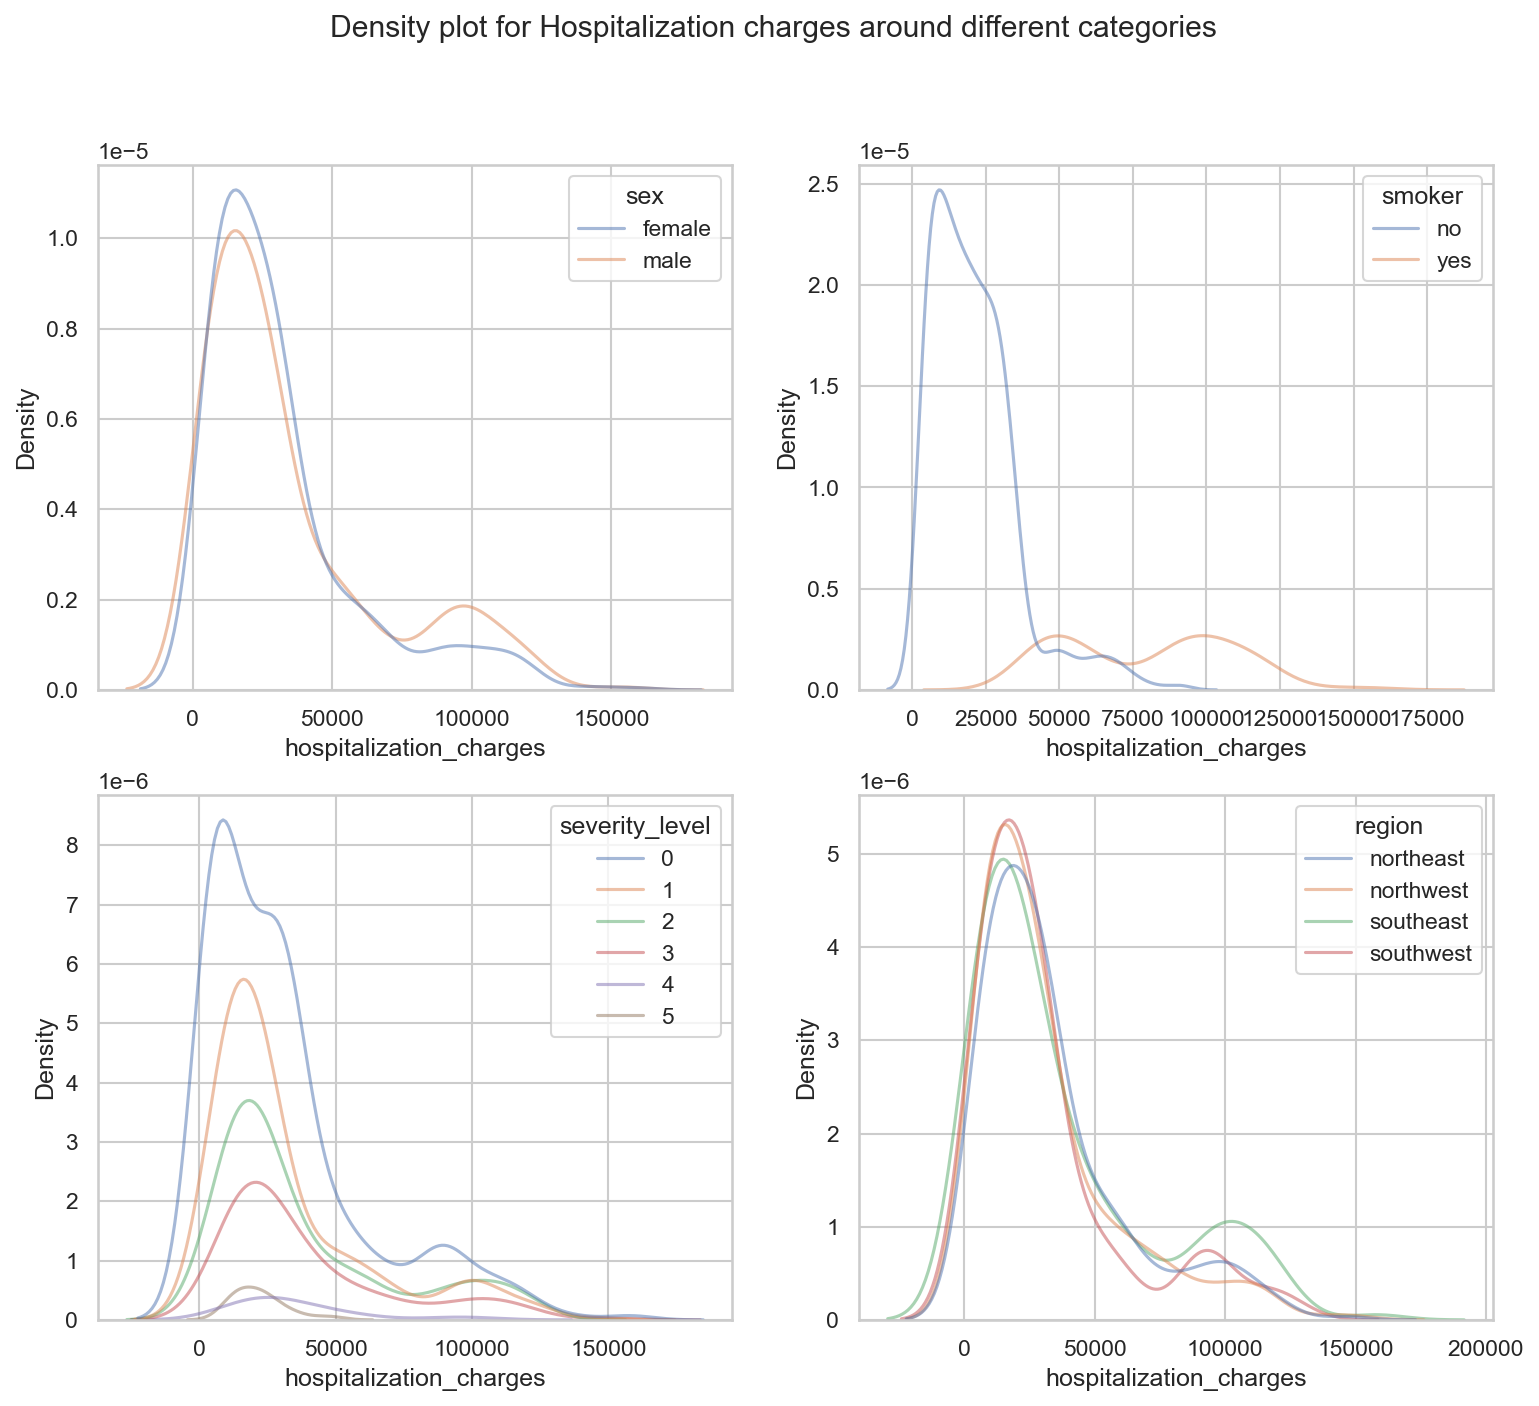

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

fig.suptitle("Density plot for Hospitalization charges around different categories")
for col, ax in zip(["sex", "smoker", "severity_level", "region"], axs.ravel()):
    sns.kdeplot(data, x="hospitalization_charges", hue=col, alpha=0.5, ax=ax)

- Density of hospitalization charges is same for different sex and regions.
- Very less data of hospitalization charges for smokers than non smokers.
- Hospitalization charges data count is decreasing as the severity is increasing.

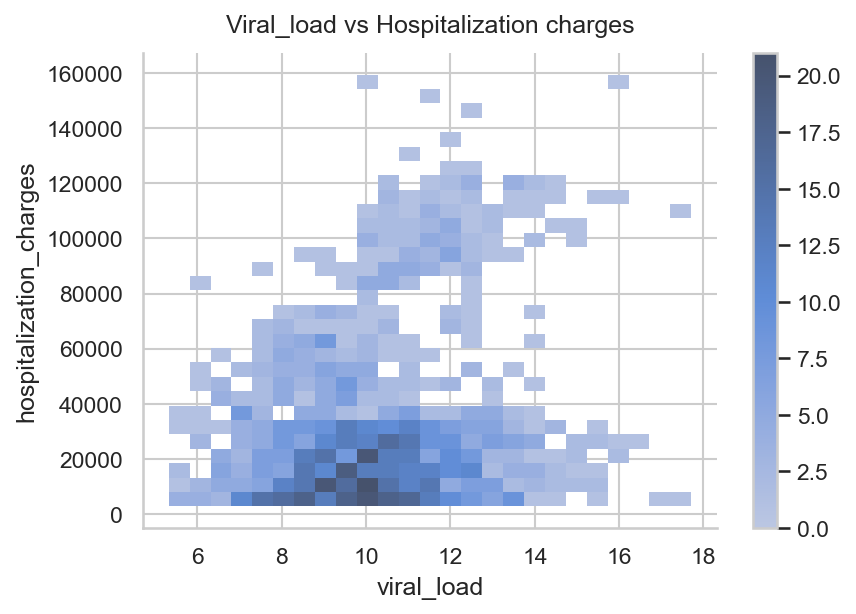

In [19]:
sns.displot(data, x="viral_load", y="hospitalization_charges",  aspect=1.5, cbar=True, height=4)
plt.title("Viral_load vs Hospitalization charges", pad=10)
plt.show()

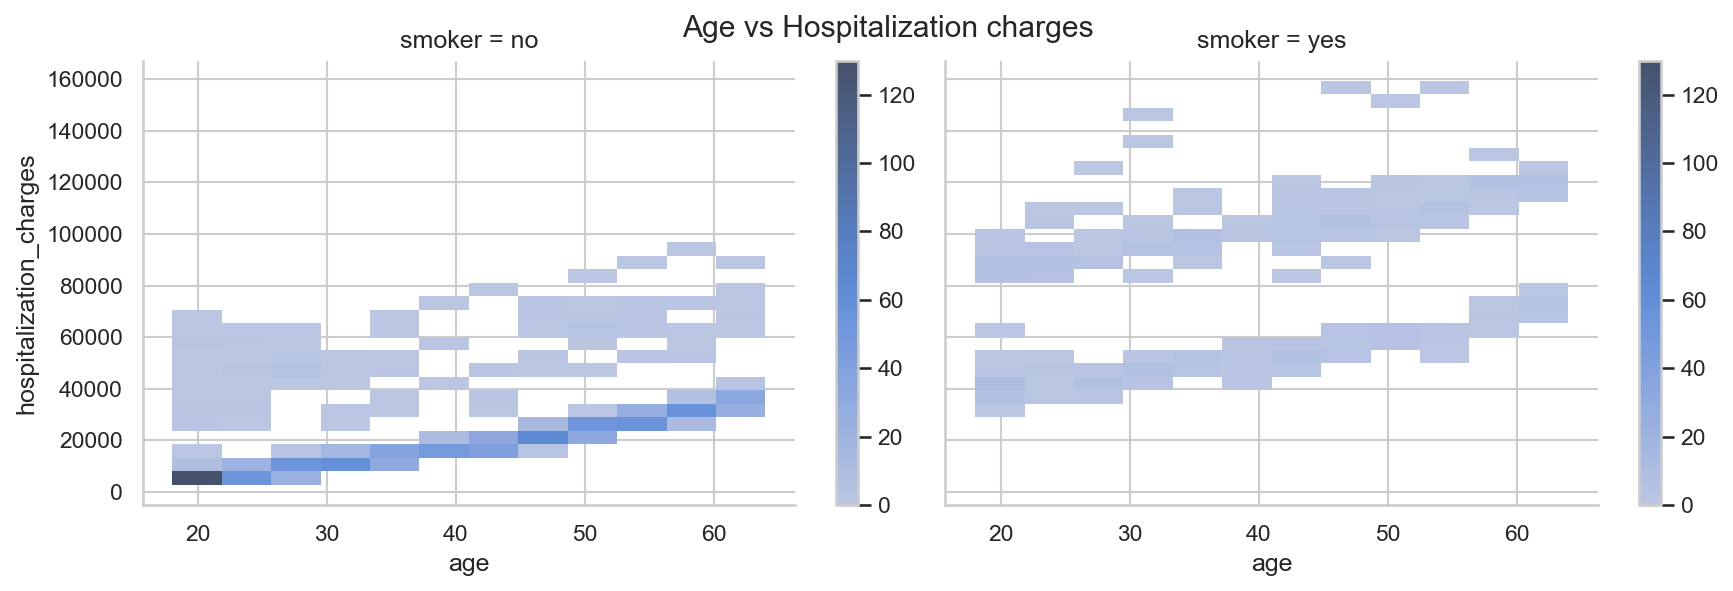

In [185]:
sns.displot(data, x="age", y="hospitalization_charges", col="smoker", aspect=1.5, cbar=True, height=4)
plt.suptitle("Age vs Hospitalization charges")
plt.show()

- Cannot see any relationship between viral load and hospitalization charges.
- Most of the points are centered around viral load of range 7 to 12 and hospitalization charges less than 40000.
- As the age is increasing hospitalization charges are also increasing.

Text(0.5, 1.0, 'Proportion plot for Smoker vs Hospitalization_charges')

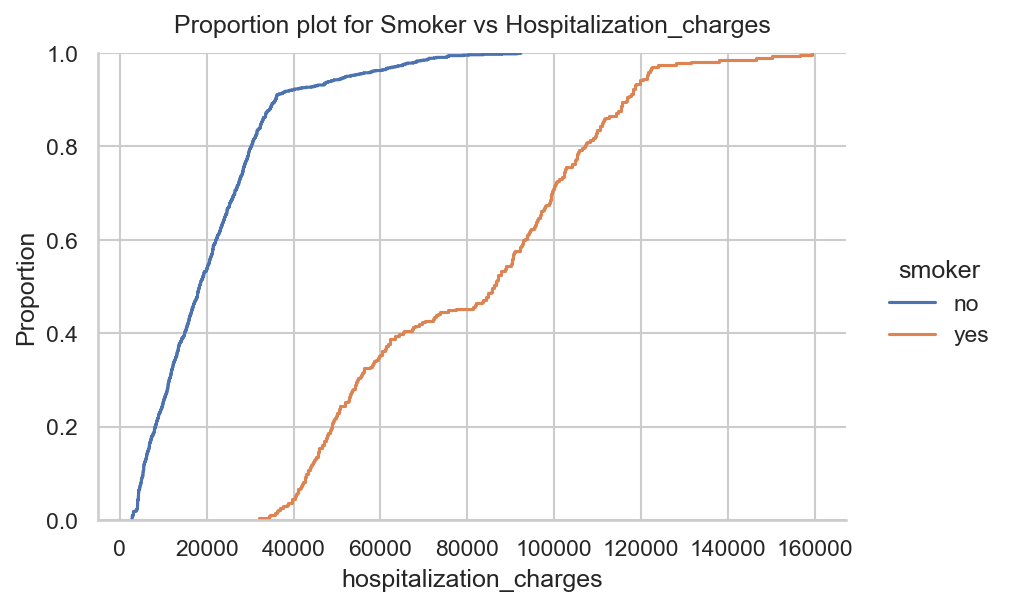

In [21]:
sns.displot(data, hue="smoker", x="hospitalization_charges", kind="ecdf", aspect=1.5, height=4)
plt.title("Proportion plot for Smoker vs Hospitalization_charges", pad=10)

<div class="alert alert-block alert-info">
<h3>Observations:</h3> 
    1. All categories sex, smoker, severity level and region are having outliers for hospitalization charges.<br>
    2. Less number of people smoking in the data and it might be same for population also.<br>
    3. Can see good relationship between age and hospitalization charges but not with viral load.<br>
    4. Clearly see the hospitalization charges are higher for smokers than non smokers.<br>
    
</div>

<hr>

## 4. Multivariate Analysis

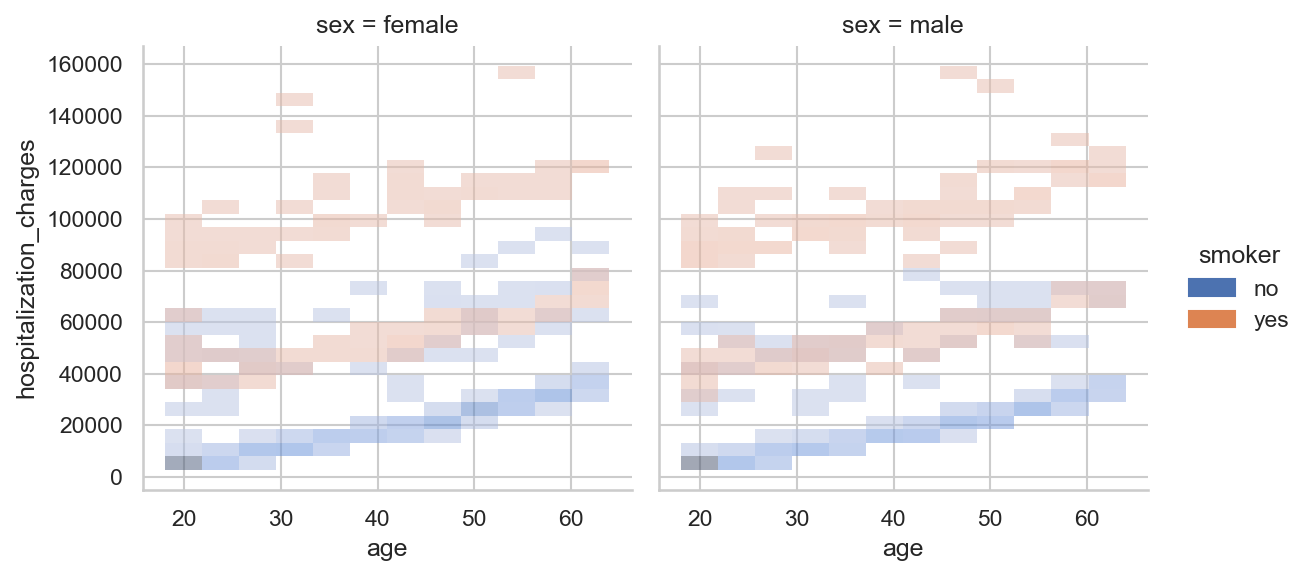

In [22]:
sns.displot(data, y="hospitalization_charges", x="age", hue="smoker", col="sex", alpha=0.5, height=4)

- Hospitalization charges are increasing as the age increasing for male, female, smoker and non smoker.

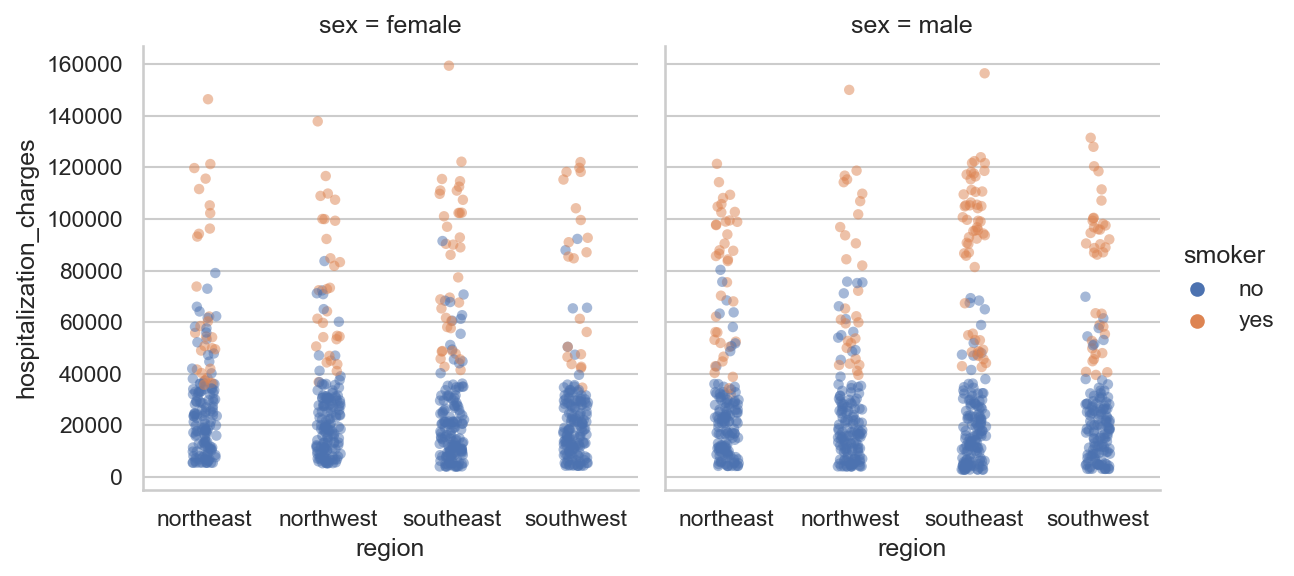

In [23]:
sns.catplot(data, y="hospitalization_charges", x="region", hue="smoker",col="sex", alpha=0.5, height=4)

- We can see same pattern across all regions that smokers are paying more than non smokers.

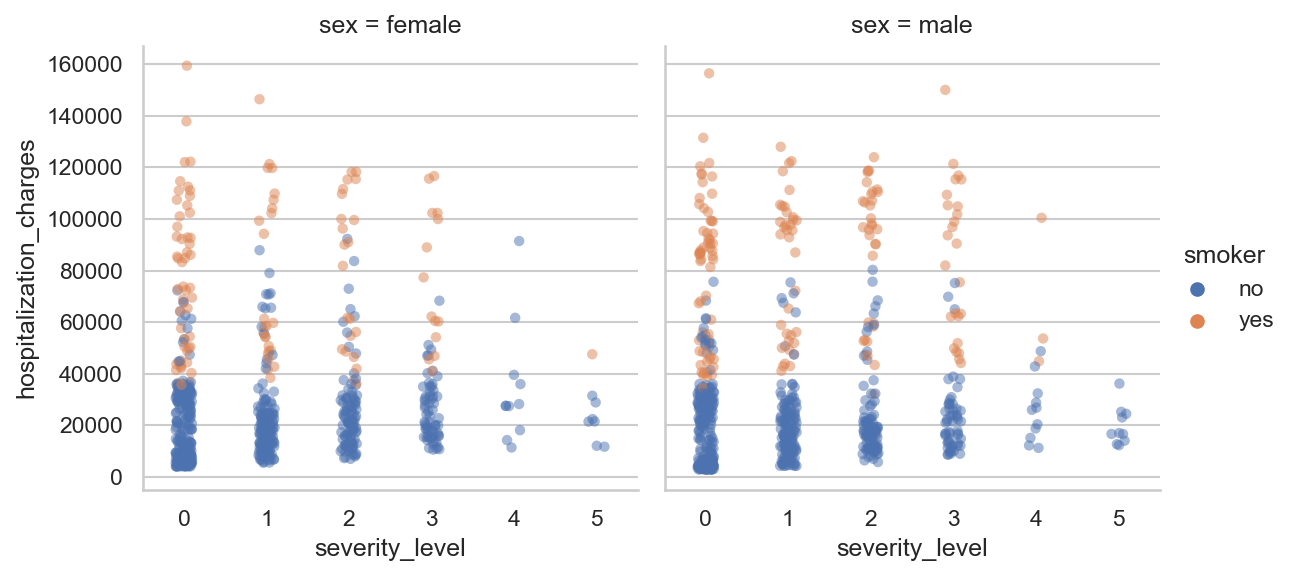

In [24]:
sns.catplot(data, y="hospitalization_charges", x="severity_level", col="sex", hue="smoker", height=4, alpha=0.5)

- Same is happening for male, female and severity level smokers are paying more than non smokers.

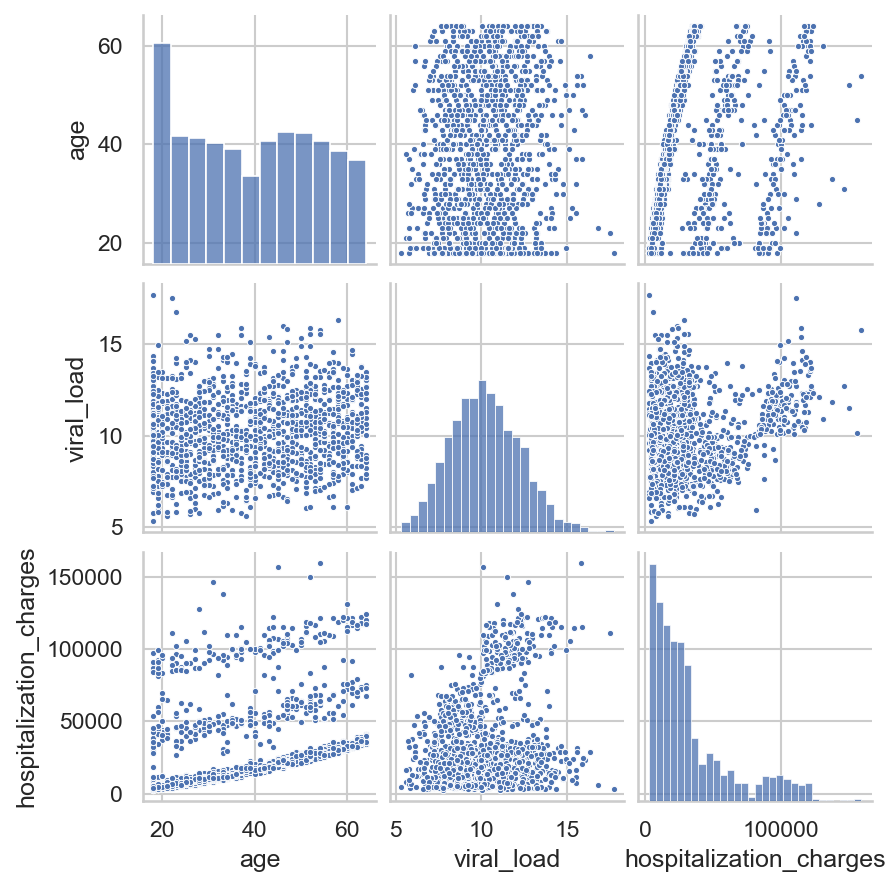

In [25]:
sns.pairplot(data, height=2, markers='.', )

<div class="alert alert-block alert-info">
<h3>Observations:</h3> 
    1. All categories sex, smoker, severity level and region are having more hospitalization charges for smokers than non smokers.<br>
    2. Hospitalization charges increases with increasing age among all categories.<br>
    
</div>

<hr>

## 5. Statistical Analysis:

In [26]:
# Encoding categorical columns
df = data.copy()

le = LabelEncoder()

for col in data.select_dtypes('category').columns:
    le.fit(df[col].drop_duplicates()) 
    df[col] = le.transform(df[col])

df.head()

,age,sex,smoker,region,viral_load,severity_level,hospitalization_charges
0,19,0,1,3,9.30,0,42212
1,18,1,0,2,11.26,1,4314
2,28,1,0,2,11.00,3,11124
3,33,1,0,1,7.57,0,54961
4,32,1,0,1,9.63,0,9667


In [27]:
# Checking severity of non-normality - feature wise

for col in data.select_dtypes(exclude=['object', 'category']).columns:
    print(f'{col}_skew: ', data[col].skew().round(2), ' '*4, f'{col}_Kurtosis: ', data[col].kurt().round(2), sep = '')


age_skew: 0.06    age_Kurtosis: -1.25
viral_load_skew: 0.28    viral_load_Kurtosis: -0.05
hospitalization_charges_skew: 1.52    hospitalization_charges_Kurtosis: 1.61


**Skewness** is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.

**Kurtosis** is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. 
That is, data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers.

In [95]:
## As Hospitalization charges are having high positive skewness let's transform to log

df["log_charges"] = np.log(df["hospitalization_charges"])

# let's check the skewness again for hospitalization charges
col1 = "hospitalization_charges"
col2 = "log_charges"

print(f'{col1}_skew: ', df[col1].skew().round(2), ' '*4, f'{col1}_Kurtosis: ', df[col1].kurt().round(2), sep = '')
print()
print(f'{col2}_skew: ', df[col2].skew().round(2), ' '*4, f'{col2}_Kurtosis: ', df[col2].kurt().round(2), sep = '')

## check data after applying boxcox transformation
# transformed_charges, best_lambda = stats.boxcox(data['hospitalization_charges'])
# display(pd.DataFrame(transformed_charges).describe().round(2).T)
## checked with boxcox but it was not good than log transformed data hence will be using that only

display(pd.DataFrame(data['hospitalization_charges']).describe().round(2).T)

display(pd.DataFrame(df["log_charges"]).describe().round(2).T)

hospitalization_charges_skew: 1.52    hospitalization_charges_Kurtosis: 1.61

log_charges_skew: -0.09    log_charges_Kurtosis: -0.64


,count,mean,std,min,25%,50%,75%,max
hospitalization_charges,1338.0,33176.06,30275.03,2805.0,11851.0,23455.0,41599.5,159426.0


,count,mean,std,min,25%,50%,75%,max
log_charges,1338.0,10.01,0.92,7.94,9.38,10.06,10.64,11.98


- As Hospitalization charges was highly skewed hence we have transformed it to log values that has decreased the skewness and kurtosis.

In [96]:
## Checking correlations

def correlation_chart(data, method='pearson'):

    # Use a sea green color palette
    cm = sns.light_palette("seagreen", as_cmap=True)
    return (
        data
        .corr(numeric_only=True, method=method)
        .style.format('{:.2}')\
            .background_gradient(cmap=cm,)\
            .set_caption(f'{method} correlation for numerical columns')
            )

display(correlation_chart(df))
print()
display(correlation_chart(df, 'spearman'))
print()
correlation_chart(df, 'kendall')

,age,sex,smoker,region,viral_load,severity_level,hospitalization_charges,log_of_charges,log_charges
age,1.0,-0.021,-0.025,0.0021,0.11,0.042,0.3,0.53,0.53
sex,-0.021,1.0,0.076,0.0046,0.046,0.017,0.057,0.0056,0.0056
smoker,-0.025,0.076,1.0,-0.0022,0.0037,0.0077,0.79,0.67,0.67
region,0.0021,0.0046,-0.0022,1.0,0.16,0.017,-0.0062,-0.043,-0.043
viral_load,0.11,0.046,0.0037,0.16,1.0,0.013,0.2,0.13,0.13
severity_level,0.042,0.017,0.0077,0.017,0.013,1.0,0.068,0.16,0.16
hospitalization_charges,0.3,0.057,0.79,-0.0062,0.2,0.068,1.0,0.89,0.89
log_of_charges,0.53,0.0056,0.67,-0.043,0.13,0.16,0.89,1.0,1.0
log_charges,0.53,0.0056,0.67,-0.043,0.13,0.16,0.89,1.0,1.0


,age,sex,smoker,region,viral_load,severity_level,hospitalization_charges,log_of_charges,log_charges
age,1.0,-0.021,-0.025,0.0043,0.11,0.057,0.53,0.53,0.53
sex,-0.021,1.0,0.076,0.0046,0.045,0.016,0.0095,0.0095,0.0095
smoker,-0.025,0.076,1.0,-0.0022,0.0023,0.017,0.66,0.66,0.66
region,0.0043,0.0046,-0.0022,1.0,0.15,0.011,-0.044,-0.044,-0.044
viral_load,0.11,0.045,0.0023,0.15,1.0,0.016,0.12,0.12,0.12
severity_level,0.057,0.016,0.017,0.011,0.016,1.0,0.13,0.13,0.13
hospitalization_charges,0.53,0.0095,0.66,-0.044,0.12,0.13,1.0,1.0,1.0
log_of_charges,0.53,0.0095,0.66,-0.044,0.12,0.13,1.0,1.0,1.0
log_charges,0.53,0.0095,0.66,-0.044,0.12,0.13,1.0,1.0,1.0


,age,sex,smoker,region,viral_load,severity_level,hospitalization_charges,log_of_charges,log_charges
age,1.0,-0.017,-0.021,0.0033,0.073,0.043,0.48,0.48,0.48
sex,-0.017,1.0,0.076,0.0042,0.037,0.014,0.0077,0.0077,0.0077
smoker,-0.021,0.076,1.0,-0.002,0.0018,0.015,0.54,0.54,0.54
region,0.0033,0.0042,-0.002,1.0,0.11,0.0087,-0.032,-0.032,-0.032
viral_load,0.073,0.037,0.0018,0.11,1.0,0.012,0.083,0.083,0.083
severity_level,0.043,0.014,0.015,0.0087,0.012,1.0,0.1,0.1,0.1
hospitalization_charges,0.48,0.0077,0.54,-0.032,0.083,0.1,1.0,1.0,1.0
log_of_charges,0.48,0.0077,0.54,-0.032,0.083,0.1,1.0,1.0,1.0
log_charges,0.48,0.0077,0.54,-0.032,0.083,0.1,1.0,1.0,1.0


- Good correlation between below columns
    - Age and Hospitalization_charges 
    - Smoker and Hospitalization_charges 
- Log of Hospitalization charges are also having good correlation with smoker and age columns.

In [169]:
# function for printing result of hypothesis testing with significance level(0.05)

def hypothesis_result(p_value, alpha=0.05):
    if p_value <= alpha: 
        print(f'pvalue is {p_value} hence Reject NULL HYPOTHESIS as pvalue < {alpha}') 
    else: 
        print(f'pvalue is {p_value} hence Fail to Reject NULL HYPOTHESIS as pvalue > {alpha}') 

#### Prove (or disprove) that the hospitalization of people who do smoking is greater than those who don't? 

*For finding the above we are performing T-test(Right tailed)*
- **Null Hypothesis ( H0 )** - Hospitalization charges for smokers and non smokers is equal.

- **Alternate Hypothesis ( HA )** - Hospitalization charges for smokers is greater than non smokers.

*Steps for doing the test -*
- Check for assumpitons of Hypothesis
    1. Normality ->
        - Check distribution of data with histogram.
        - **Shapiro-Wilk test** - is a test of the composite hypothesis that the data are i.i.d. (independent and identically distributed) and normal, i.e. N(µ, σ2) for some unknown real µ and some σ > 0.
        
            Null Hypothesis(H0) - Data following Normal distribution
            
            Alternate Hypothesis(HA) - Not following Normal distribution
        - QQ plot

        
    2. Checking Homogeneity of Variances ->
        Equal variances across samples is called homogeneity of variance
        
        - **Levene's test** - tests the null hypothesis that all input samples are from populations with equal variances. Some statistical tests, for example the analysis of variance, assume that variances are equal across groups or samples. The Levene test can be used to verify that assumption.
        
            Null Hypothesis(H0) - Homogenous Variance (variance among different groups is equal)
            
            Alternate Hypothesis(HA) - Non Homogenous variance (variance among different groups is not equal )
            
- Calculate appropriate test statistic and p value for the hypothesis.
- Check for hypothesis result.


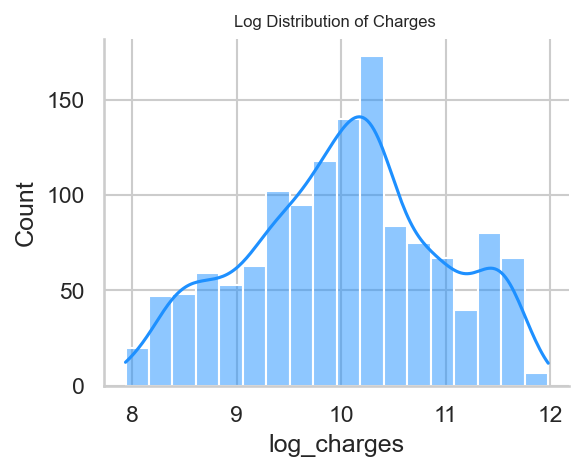

In [98]:
## Let's first check the histogram for log of hospitalization charges

plt.figure(figsize=(4,3))
sns.histplot(data = df, x = 'log_charges', color = 'dodgerblue', kde = True, )
plt.title("Log Distribution of Charges ",fontsize = 8)
sns.despine()
plt.show()


Log of hospitalization charges are roughly following the normal distribution.

In [99]:
# Assessing Normality using Shapiro Wilk test

stats.shapiro(df["log_charges"])

ShapiroResult(statistic=0.9831621050834656, pvalue=2.285247338584817e-11)

p_value is coming less than 0.05 hence we reject the Null hypothesis and Log of hospitalization charges are not following Normal distribution.

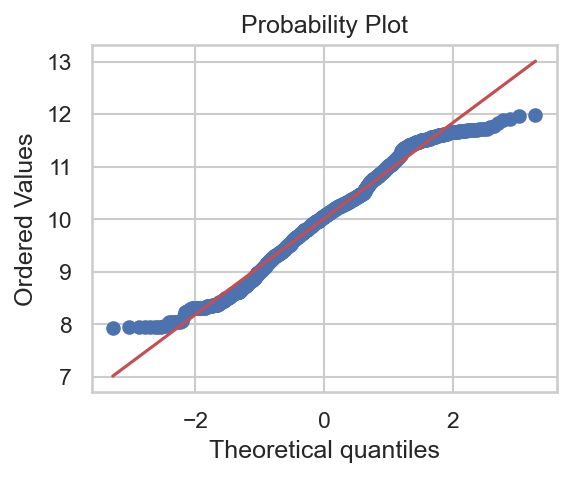

In [118]:
# Let's check the QQ plot

plt.figure(figsize=(4,3))
stats.probplot(df["log_charges"], plot=plt)
plt.show()

We can see  that log of hospitalization charges are roughly falling on the QQ plot line and dataset is fairly large, hence we can conclude that hospitalization charges likely to follow Normal Distribution

In [63]:
# Dividing charges of smoker and non smoker and comparing mean

non_smoker_charges = np.log(data.query('smoker == "no"').hospitalization_charges.values)
smoker_charges = np.log(data.query('smoker == "yes"').hospitalization_charges.values)

non_smoker_charges.mean(), smoker_charges.mean()

(9.704523805276631, 11.220400077909767)

We can see there is a significant difference between mean charges of smokers and non smoker.

We are going to prove this statistically via right tailed ttest.

<Axes: xlabel='log_charges', ylabel='Density'>

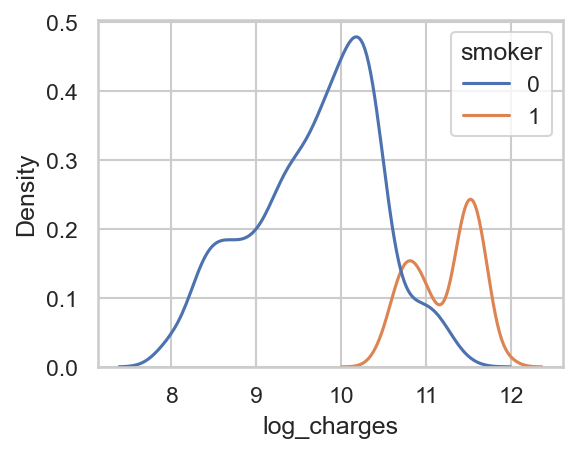

In [121]:
plt.figure(figsize=(4,3))
sns.kdeplot(df, x="log_charges", hue="smoker")

We can see non smokers charges are roughly following normal but smokers charges are not following Normal distribution.

In [147]:
## As we have seen above hospitalization charges are having many outliers 
## so let's check skewness and kurtosis for both smokers and non smokers

print(f"smoker_charges skewness {round(stats.skew(smoker_charges), 2)} \t \
      non_smoker_charges skewness {round(stats.skew(non_smoker_charges), 2)}")

print()

print(f"smoker_charges kurtosis {round(stats.kurtosis(smoker_charges), 2)} \t \
      non_smoker_charges kurtosis {round(stats.kurtosis(non_smoker_charges), 2)}")

smoker_charges skewness -0.3 	       non_smoker_charges skewness -0.31

smoker_charges kurtosis -1.23 	       non_smoker_charges kurtosis -0.51


We can see form above that skewness and kurtosis is less for non smoker charges.

But smoker charges are having high kurtosis and less skewness

In [127]:
## Lets check for homogeneity of variances

_, pvalue = stats.levene(smoker_charges,non_smoker_charges)
hypothesis_result(pvalue)

Reject NULL HYPOTHESIS


We are rejecting null hypothesis of levene test that means there is significant difference between variances of smokers and non smoker charges.

In [166]:
_, pvalue = stats.ttest_ind(smoker_charges, non_smoker_charges, alternative='greater', equal_var=False)
hypothesis_result(pvalue)

pvalue is 1.960024096886002e-234 hence Reject NULL HYPOTHESIS with alpha 0.05


**We reject the Null Hypothesis, which means hospitalization charges are higher for smokers than non smokers.**

### Prove (or disprove) with statistical evidence that the viral load of females is different from that of males?

For answering the above we will be performing Two tailed t test where
- Null Hypothesis ( H0 ) - Viral load of female and male is equal.

- Alternate Hypothesis ( HA ) - Viral load of female and male is not equal.

*Steps to perform* -
- Checking for basic assumpitons for the hypothesis
    - Normality check
    - Homogeneity of Variances

- Perform two tailed t test - A two tailed test tells you that you’re finding the area in the middle of a distribution. In other words, your rejection region (the place where you would reject the null hypothesis) is in both tails.

- Checking for hypothesis result

In [130]:
viral_f = data.query('sex=="female"')["viral_load"].values
viral_m = data.query('sex=="male"')["viral_load"].values

We have already seen in EDA that viral load is approximately following Normal distribution so let's confirm it via QQ plot too.

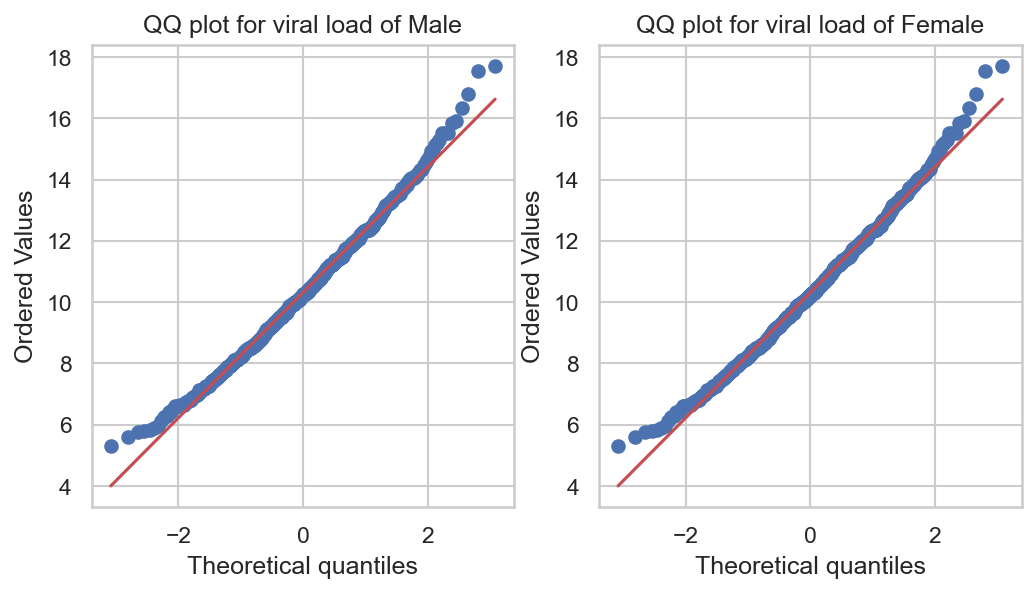

In [142]:
fig, ax = plt.subplots(1, 2,  figsize=(8, 4))
stats.probplot(viral_m, plot=ax[0], dist='norm')
ax[0].set_title("QQ plot for viral load of Male")

stats.probplot(viral_m, plot=ax[1], dist='norm')
ax[1].set_title("QQ plot for viral load of Female")
plt.show()

Viral load for both male and female are roughly following Normal distribution

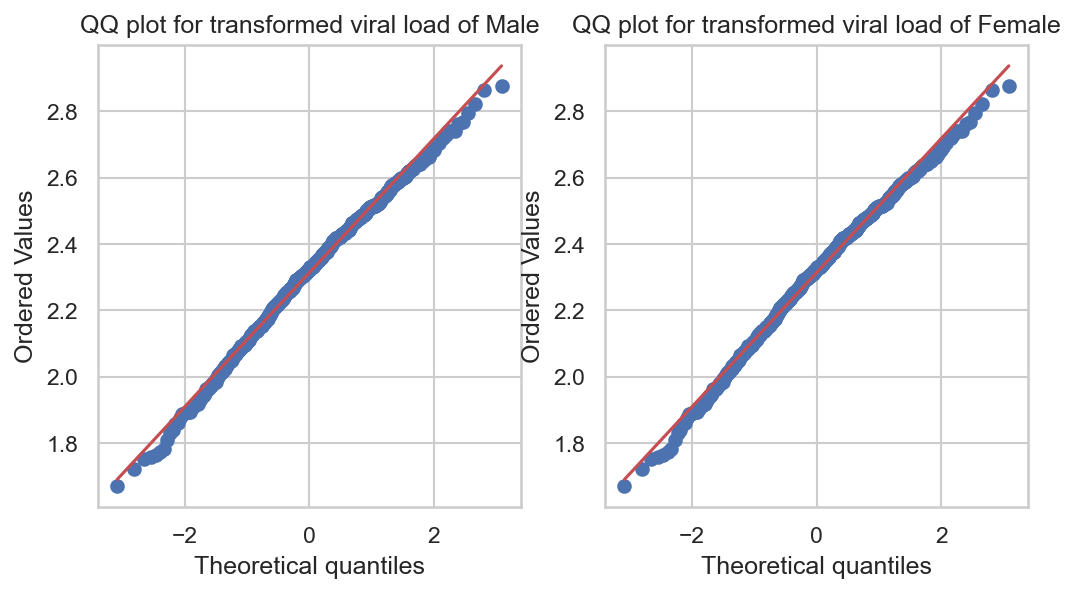

In [149]:
## Lets check for log transformed viral load to check for Normality

fig, ax = plt.subplots(1, 2,  figsize=(8, 4))
stats.probplot(np.log(viral_m), plot=ax[0], dist='norm')
ax[0].set_title("QQ plot for transformed viral load of Male")

stats.probplot(np.log(viral_m), plot=ax[1], dist='norm')
ax[1].set_title("QQ plot for transformed viral load of Female")
plt.show()

We can see not much improvement with log transformation so let's try Boxcox transfromation

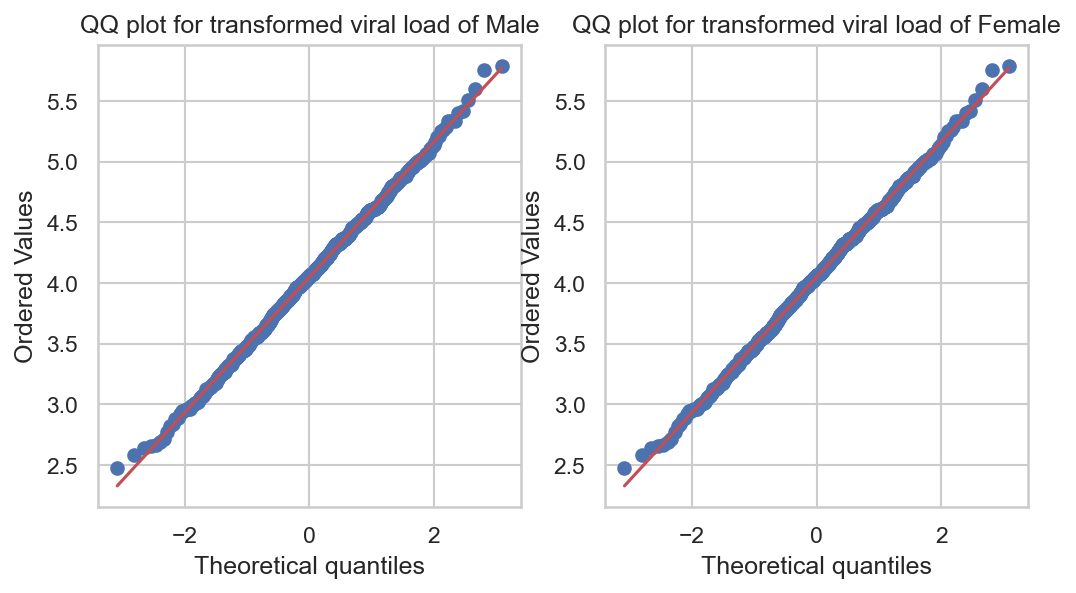

In [156]:
## Lets check for boxcox transformed viral load to check for Normality

fig, ax = plt.subplots(1, 2,  figsize=(8, 4))
stats.probplot(stats.boxcox(viral_m)[0], plot=ax[0], dist='norm')
ax[0].set_title("QQ plot for transformed viral load of Male")

stats.probplot(stats.boxcox(viral_m)[0], plot=ax[1], dist='norm')
ax[1].set_title("QQ plot for transformed viral load of Female")
plt.show()

Now viral load is following Normal distribution lets confirm with shapiro-wilk test

In [170]:
## Checking Normality with Shapiro-Wilk test

_, pvalue = stats.shapiro(stats.boxcox(data.viral_load)[0])
hypothesis_result(pvalue)

pvalue is 0.3490143120288849 hence Fail to Reject NULL HYPOTHESIS as pvalue > 0.05


We fail to reject null hypothesis, which means boxcox transformed viral load data is following Normal distribution.

In [181]:
## Checking Homogeneity
_, pvalue = stats.levene(viral_m, viral_f)
hypothesis_result(pvalue)

pvalue is 0.9503708012456551 hence Fail to Reject NULL HYPOTHESIS as pvalue > 0.05


We fail to reject Null Hypothesis hence, viral load variance is same for Male and Female.

In [171]:
## Performing ttest for viral load for male and female

_, pvalue = stats.ttest_ind(viral_f, viral_m)
hypothesis_result(pvalue)


pvalue is 0.0901735841670204 hence Fail to Reject NULL HYPOTHESIS as pvalue > 0.05


**We fail to reject null hypothesis, which means the mean viral load is same for Female and Male.**


### Is the proportion of smoking significantly different across different regions? 


For answering the above we will be performing Chi-Square test where
- Null Hypothesis ( H0 ) - Proportion of smoking is equal across different regions.

- Alternate Hypothesis ( HA ) - Proportion of smoking is different across different regions.

*Steps to perform* -
- Checking for basic assumpitons for the hypothesis
    - Both variables are categorical.
    - All observations are independent.
    - Cells in the contingency table are mutually exclusive.
    - Expected value of cells should be 5 or greater in at least 80% of cells.

- Perform Chi-Square test - It is used to compare observed and expected results. The goal of this test is to identify whether a disparity between actual and predicted data is due to chance or to a link between the variables under consideration. As a result, the chi-square test is an ideal choice for aiding in our understanding and interpretation of the connection between our two categorical variables.

- Checking for hypothesis result

In [155]:
observed = pd.crosstab(index=data["region"], columns=data["smoker"])
observed

smoker,no,yes
region,,
northeast,257,67
northwest,267,58
southeast,273,91
southwest,267,58


We can see from above contigency table that it is following all assumptions.

In [173]:
## Performing Chi square test 

_, pvalue, dof, expected = stats.chi2_contingency(observed.values)

hypothesis_result(pvalue)

pvalue is 0.06171954839170541 hence Fail to Reject NULL HYPOTHESIS as pvalue > 0.05


**We fail to reject null hypothesis, which means the proportion of smoking is same across different regions.**

### Is the mean viral load of women with 0 Severity level , 1 Severity level, and 2 Severity level the same? 

*For checking above we are performing One-way Anova -* 
- Null Hypothesis ( H0 ) - Mean viral_load for females of severity 1,2,3 is same.

- Alternate Hypothesis ( HA ) - Mean viral_load for females of severity 1,2,3 is different.

*Steps to perform* -
- Checking for basic assumpitons for the hypothesis
    - Normality check
    - Homogeneity of Variances

- Performing One-way Anova - The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean. The test is applied to samples from two or more groups, possibly with differing sizes.

    The reason why it's called an one-way or one factor ANOVA even though there are 3 or more groups being tested is because those groups are under one categorical variable, such as race or education level, and the name is referring to the number of variables in the analysis and not the number of groups. If there are two variables being compared it would technically be called a two-way, or two factor

- Checking for hypothesis result

In [176]:
## We have already checked for the Normality of viral load

female = data.query('sex=="female"')

f_sev_0 = female.query('severity_level==0')['viral_load']
f_sev_1 = female.query('severity_level==1')['viral_load']
f_sev_2 = female.query('severity_level==2')['viral_load']
f_sev_3 = female.query('severity_level==3')['viral_load']
f_sev_4 = female.query('severity_level==4')['viral_load']
f_sev_5 = female.query('severity_level==5')['viral_load']

In [182]:
## Checking Homogeneity

_, p = stats.levene(f_sev_0, f_sev_1, f_sev_2, f_sev_3, f_sev_4, f_sev_5)
hypothesis_result(p)

pvalue is 0.34351119323222323 hence Fail to Reject NULL HYPOTHESIS as pvalue > 0.05


**We fail to reject null hypothesis, which means the variance is same across the groups.**


In [183]:
## Performing One way Anova
_, pvalue = stats.f_oneway(f_sev_0, f_sev_1, f_sev_2, f_sev_3, f_sev_4, f_sev_5)
hypothesis_result(pvalue)

pvalue is 0.9185708092374022 hence Fail to Reject NULL HYPOTHESIS as pvalue > 0.05


**We fail to reject null hypothesis, which means the mean viral load for females of severity levels 0,1,2 is same.**


<hr>

<div class="alert alert-block alert-info">
<h3>Summary:</h3> 
    <ol>
    <li>Hospitalization charges are increasing as the age increases.</li>
    <li>We have observed that smokers are paying high hospitalization charges than non smokers.</li>
    <li>Across all regions smokers proportion is same and no significant difference in hospitalization charges.</li>
    <li>No relationship found between viral load and hospitalization charges.</li>
    <li>There is no difference for hospitalization charges between female and male smokers.</li>
    <li>Severity level is also not a good indicater of hospitalization charges</li>
    <li>Women with any number of severity level have almost same same viral load as observed by hypothesis testing.</li>
    </ol>
    <br>

<h3>Recommendations:</h3>
    <ol>
    <li>We should make aware people to have a healthy lifestyle and also an emergency fund with a good health insurance as people getting older are paying more charges.</li>
    <li>We should promote no smoking as smokers are the people with high hospitalization charges.</li>
    <li>Let people know that more viral level or severity level does not mean more hospitalization charges as seen from data there is no significant relationship between them. This will bring trust in patients that we don't charge unnecessarily</li>
    </ol>
</div>

